In [3]:
import os, random, time
from pathlib import Path

SEED = 42

# Set environment variables for reproducibility BEFORE importing torch
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as Fun
import torchvision.transforms.v2 as transforms
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from fiftyone import ViewField as F
import fiftyone.utils.random as four
from tqdm import tqdm
from torch.optim import Adam
from pathlib import Path
import matplotlib.pyplot as plt

In [4]:
PROJECT_NAME = "Assignment-01"
DELETE_EXISTING_DATASETS = True

In [5]:
BASE_PATH = Path.cwd()
DATA_PATH = BASE_PATH / "data"
MODEL_PATH = BASE_PATH / "models"
EXAMPLES_PATH = BASE_PATH / "examples"
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(EXAMPLES_PATH, exist_ok=True)

In [91]:
# Define batch size
BATCH_SIZE = 64
NUM_WORKERS = 0 # We use GPU, so we set num_workers to 0

In [7]:
def set_seeds(seed: int):
    """
    Set seeds for complete reproducibility across all libraries and operations.

    Args:
        seed (int): Random seed value
    """
    # Set environment variables before other imports
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    # Python random module
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch GPU (all devices)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

        # CUDA deterministic operations
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # PyTorch deterministic algorithms (may impact performance)
    try:
        torch.use_deterministic_algorithms(True)
    except RuntimeError:
        # Some operations don't have deterministic implementations
        print("Warning: Some operations may not be deterministic")

    print(f"All random seeds set to {seed} for reproducibility")



# Usage: Call this function at the beginning and before each training phase
set_seeds(SEED)

# Additional reproducibility considerations:

def create_deterministic_training_dataloader(dataset, batch_size, shuffle=True, **kwargs):
    """
    Create a DataLoader with deterministic behavior.

    Args:
        dataset: PyTorch Dataset instance
        batch_size: Batch size
        shuffle: Whether to shuffle data
        **kwargs: Additional DataLoader arguments

    Returns:
        Training DataLoader with reproducible behavior
    """
    # Use a generator with fixed seed for reproducible shuffling
    generator = torch.Generator()
    generator.manual_seed(SEED)

    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        generator=generator if shuffle else None,
        **kwargs
    )

All random seeds set to 42 for reproducibility


In [ ]:
# Function to view a FiftyOne session with error handling
def view(session, view, dataset):
    try:
        session.view = view
        session.refresh()
        session.show()
    except Exception as e:
        session = fo.launch_app(dataset, auto=False, port=4242)
        session.view = view
        session.refresh()
        session.show()
    time.sleep(5)

In [ ]:
# Define dataset names
dataset_names = {
        "train-val": "mnist-train-val-set",
        "train": "mnist-train-set",
        "val": "mnist-validation-set",
        "test": "mnist-test-set",
        "train-val-IDK": "mnist-train-val-IDK-set",
        "train-IDK": "mnist-train-IDK-set",
        "val-IDK": "mnist-val-IDK-set",
        "test-IDK": "mnist-test-IDK-set",
    }

In [ ]:
if DELETE_EXISTING_DATASETS:
    for ds in fo.list_datasets():
        print(f"Dataset '{ds}' already exists. Deleting it.")
        fo.delete_dataset(ds)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data Preparation

In [ ]:
# Get Train-Val Dataset
if dataset_names["train-val"] in fo.list_datasets():
    print(f"Dataset '{dataset_names['train-val']}' already exists. Loading it.")
    train_val_dataset = fo.load_dataset(dataset_names["train-val"])
else:
    print(f"Downloading and preparing dataset '{dataset_names['train-val']}'...")
    train_val_dataset = foz.load_zoo_dataset("mnist",
                                            split='train',
                                            dataset_name=dataset_names["train-val"],
                                            persistent=True)
    train_val_dataset.compute_metadata()
    train_val_dataset.untag_samples(["train", "validation"])

In [ ]:
if not dataset_names["train"] in fo.list_datasets() or not dataset_names["val"] in fo.list_datasets():    
    # Create random 85%/15% split using tags
    four.random_split(train_val_dataset,
                    {"train": 0.85, "validation": 0.15},
                    # The seed makes the split reproducible
                    seed=SEED)

    # Verify the split by counting tags
    tag_counts = train_val_dataset.count_sample_tags()
    print("Tag counts after split:")
    print(tag_counts)

    # Separate validation and train FO datasets
    train_dataset = train_val_dataset.match_tags("train").clone()
    val_dataset = train_val_dataset.match_tags("validation").clone()

    # Set names for FO datasets using the 'name' property
    train_dataset.name = dataset_names["train"]
    val_dataset.name = dataset_names["val"]

    # Define persistency
    train_dataset.persistent = True
    val_dataset.persistent = True
else:
    print(f"Datasets '{dataset_names['train']}' and '{dataset_names['val']}' already exist. Loading them.")
    train_dataset = fo.load_dataset(dataset_names["train"])
    val_dataset = fo.load_dataset(dataset_names["val"])

In [ ]:
# Get Test Dataset
if dataset_names["test"] in fo.list_datasets():
    print(f"Dataset '{dataset_names['test']}' already exists. Loading it.")
    test_dataset = fo.load_dataset(dataset_names["test"])
else:
    print(f"Downloading and preparing dataset '{dataset_names['test']}'...")
    test_dataset = foz.load_zoo_dataset(
        "mnist",
        split="test",
        dataset_name=dataset_names["test"],
        persistent=True
    )
    test_dataset.compute_metadata()

In [14]:
# Get Label Map
dataset_classes = sorted(train_dataset.distinct("ground_truth.label"))
label_map = {string_label: index for index, string_label in enumerate(dataset_classes)}
label_map

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [15]:
# Custom PyTorch Dataset class for MNIST training data
class CustomTorchImageDataset(torch.utils.data.Dataset):
    def __init__(self, fiftyone_dataset,
                 image_transforms=None,
                 label_map=None,
                 gt_field="ground_truth"):
        self.fiftyone_dataset = fiftyone_dataset
        self.image_paths = self.fiftyone_dataset.values("filepath")
        self.str_labels = self.fiftyone_dataset.values(f"{gt_field}.label")
        self.image_transforms = image_transforms

        if label_map is None:
            self.label_map = {str(i): i for i in range(10)}
        else:
            self.label_map = label_map

        print(f"CustomTorchImageDataset initialized with {len(self.image_paths)} samples.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert('L') # Convert to grayscale
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return torch.randn(1, 28, 28), torch.tensor(-1, dtype=torch.long)

        if self.image_transforms:
            image = self.image_transforms(image)

        label_str = self.str_labels[idx]
        label_idx = self.label_map.get(label_str, -1)
        if label_idx == -1:
            print(f"Warning: Label '{label_str}' not in label_map for image {image_path}")

        return image, torch.tensor(label_idx, dtype=torch.long)

In [16]:
# Define image transformations
IMAGE_TRANSFORMS = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True), # Scale to [0, 1]
])

In [17]:
# Create a PyTorch Dataset for the train set
torch_train_set = CustomTorchImageDataset(train_dataset,
                                          label_map=label_map,
                                          image_transforms=IMAGE_TRANSFORMS)

# Create a PyTorch Dataset for the validation set
torch_val_set = CustomTorchImageDataset(val_dataset,
                                     label_map=label_map,
                                     image_transforms=IMAGE_TRANSFORMS)

# Create a PyTorch Dataset for the test set
torch_test_set = CustomTorchImageDataset(test_dataset,
                                      label_map=label_map,
                                      image_transforms=IMAGE_TRANSFORMS)

CustomTorchImageDataset initialized with 51000 samples.
CustomTorchImageDataset initialized with 9000 samples.
CustomTorchImageDataset initialized with 10000 samples.


In [ ]:
# Create a PyTorch DataLoader for the train set
train_loader = create_deterministic_training_dataloader(
    torch_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
print("Train DataLoader created successfully.")
print(f"Train DataLoader has {len(train_loader)} batches.")

# Create a PyTorch DataLoader for the validation set
val_loader = torch.utils.data.DataLoader(
    torch_val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
print("Validation DataLoader created successfully.")
print(f"Validation DataLoader has {len(val_loader)} batches.")

# Create a PyTorch DataLoader for the test set
test_loader = torch.utils.data.DataLoader(
    torch_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("Test DataLoader created successfully.")
print(f"Test DataLoader has {len(test_loader)} batches.")


Train DataLoader created successfully.
Train DataLoader has 797 batches.
Validation DataLoader created successfully.
Validation DataLoader has 282 batches.
Test DataLoader created successfully.
Test DataLoader has 313 batches.


# Model Definition

In [19]:
class ModernLeNet5(nn.Module):
    """
    Modernized version of LeNet-5 with ReLU activations and max pooling.
    Often performs better on MNIST than the original version.
    """

    def __init__(self, num_classes=10):
        super(ModernLeNet5, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=4)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)

        self.dropout = nn.Dropout(0.5)

        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [20]:
model = ModernLeNet5().to(device)

ce_loss = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),
                 lr=0.003, betas=(0.9, 0.999),
                 eps=1e-08, weight_decay=0)

In [ ]:
def train_epoch(model, train_loader):
  batch_losses = []
  correct = 0
  total = 0

  model.train()
  for images, labels in tqdm(train_loader, desc="Training: "):

      images = images.to(device)
      labels = labels.to(device)

      logits = model(images)
      loss_value = ce_loss(logits, labels)

      optimizer.zero_grad()

      loss_value.backward()

      optimizer.step()

      batch_losses.append(loss_value.item())
      preds = logits.argmax(dim=1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

  train_loss = np.mean(batch_losses)
  train_acc = correct / total
  return train_loss, train_acc


In [ ]:
def val_epoch(model, val_loader):
  batch_losses = []
  correct = 0
  total = 0

  model.eval()
  with torch.inference_mode():
    for images, labels in tqdm(val_loader, desc="Validation: "):
      images = images.to(device)
      labels = labels.to(device)

      logits = model(images)
      loss_value = ce_loss(logits, labels)

      batch_losses.append(loss_value.item())
      preds = logits.argmax(dim=1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

  val_loss = np.mean(batch_losses)
  val_acc = correct / total
  return val_loss, val_acc

# Training

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_model = None

model_save_path = MODEL_PATH / 'best_lenet.pth'

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc = val_epoch(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

        torch.save(best_model.state_dict(), model_save_path)
        print('Found and saved better weights for the model')

Validation: 100%|██████████| 282/282 [00:06<00:00, 43.67it/s]


Epoch 1/10 - Train Loss: 0.3016 - Train Acc: 0.9095 - Val Loss: 0.1015 - Val Acc: 0.9690
Found and saved better weights for the model


Validation: 100%|██████████| 282/282 [00:06<00:00, 45.03it/s]


Epoch 2/10 - Train Loss: 0.0997 - Train Acc: 0.9736 - Val Loss: 0.0809 - Val Acc: 0.9760
Found and saved better weights for the model


Validation: 100%|██████████| 282/282 [00:06<00:00, 40.49it/s]


Epoch 3/10 - Train Loss: 0.0748 - Train Acc: 0.9807 - Val Loss: 0.0575 - Val Acc: 0.9829
Found and saved better weights for the model


Validation: 100%|██████████| 282/282 [00:06<00:00, 43.64it/s]


Epoch 4/10 - Train Loss: 0.0583 - Train Acc: 0.9839 - Val Loss: 0.0400 - Val Acc: 0.9883
Found and saved better weights for the model


Validation: 100%|██████████| 282/282 [00:05<00:00, 47.01it/s]


Epoch 5/10 - Train Loss: 0.0505 - Train Acc: 0.9871 - Val Loss: 0.0634 - Val Acc: 0.9838


Validation: 100%|██████████| 282/282 [00:06<00:00, 44.81it/s]


Epoch 6/10 - Train Loss: 0.0457 - Train Acc: 0.9875 - Val Loss: 0.0452 - Val Acc: 0.9882


Validation: 100%|██████████| 282/282 [00:06<00:00, 45.50it/s]


Epoch 7/10 - Train Loss: 0.0416 - Train Acc: 0.9884 - Val Loss: 0.0577 - Val Acc: 0.9843


Validation: 100%|██████████| 282/282 [00:05<00:00, 47.06it/s]


Epoch 8/10 - Train Loss: 0.0375 - Train Acc: 0.9895 - Val Loss: 0.0561 - Val Acc: 0.9837


Validation: 100%|██████████| 282/282 [00:06<00:00, 40.94it/s]


Epoch 9/10 - Train Loss: 0.0357 - Train Acc: 0.9905 - Val Loss: 0.0528 - Val Acc: 0.9868


Validation: 100%|██████████| 282/282 [00:06<00:00, 45.20it/s]

Epoch 10/10 - Train Loss: 0.0316 - Train Acc: 0.9913 - Val Loss: 0.0623 - Val Acc: 0.9870


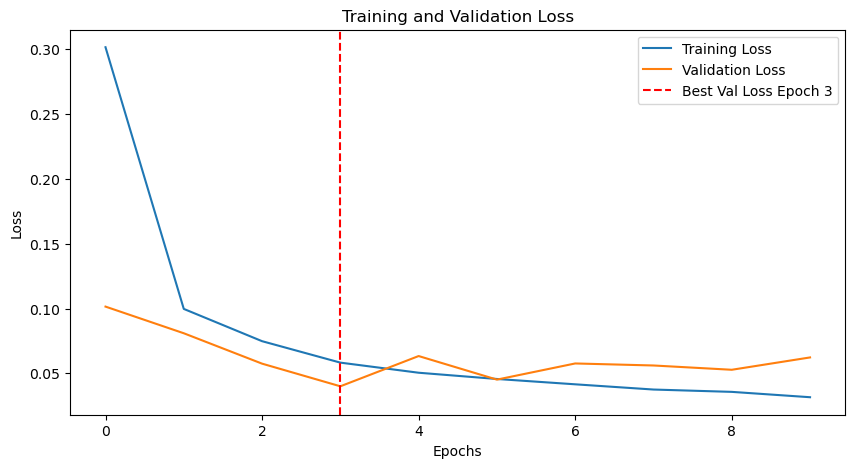

In [ ]:
plt.figure(figsize=(num_epochs, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

best_epoch = np.argmin(val_losses)
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Val Loss Epoch {best_epoch}')
plt.legend()

plt.savefig(EXAMPLES_PATH / "training_validation_loss.png")
plt.show()

# Evaluate the best Model

In [111]:
model_save_path = MODEL_PATH / 'best_lenet.pth'

device = "cuda" if torch.cuda.is_available() else "cpu"

loaded_model = ModernLeNet5()
loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))
loaded_model = loaded_model.to(device)

print(f"Model loaded.")
print(f"Model is on device: {next(loaded_model.parameters()).device}")
loaded_model.eval()

Model loaded.
Model is on device: cuda:0


ModernLeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [ ]:
def apply_model_to_evaluate(model, loader, dataset, set_name="", label_map=None):
    predictions = []
    all_logits = []

    # Invert label_map: index -> label string
    if label_map is not None:
        idx_to_label = {v: k for k, v in label_map.items()}
    else:
        # Fallback to dataset_classes if not provided
        idx_to_label = {i: l for i, l in enumerate(dataset_classes)}

    # Run inference on the dataset
    print(f"Applying best LeNet model to the {set_name + ' set'}...")
    with torch.inference_mode():
        for images, _ in tqdm(loader):
            images = images.to(device)

            logits = model(images)
            all_logits.append(logits.cpu().numpy())

            _, predicted = torch.max(logits.data, 1)
            predictions.extend(predicted.cpu().numpy())

    all_logits = np.concatenate(all_logits, axis=0)

    print(f"Inference on {set_name + ' set'} complete.")
    print(f"Shape of collected logits: {all_logits.shape}")
    print(f"Number of collected predictions: {len(predictions)}")

    print(f"Storing predictions and logits as FiftyOne Classifications for the {set_name + ' set'}...")

    for i, sample in enumerate(dataset):
        # Get the predicted class index and corresponding class name
        predicted_idx = predictions[i]
        predicted_label = idx_to_label[predicted_idx]

        sample_logits = all_logits[i]
        confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
        predicted_confidence = float(confidences[predicted_idx])

        # Create FiftyOne Classification object with prediction
        classification = fo.Classification(
            label=predicted_label,
            confidence=predicted_confidence,
            logits=sample_logits.tolist()
        )

        sample["lenet_classification"] = classification
        sample.save()

## Evaluate on Test Set

In [ ]:
## Apply best_model to the test set
apply_model_to_evaluate(
    model=loaded_model,
    loader=test_loader,
    dataset=test_dataset,
    set_name="test"
)

Applying best LeNet model to the test set...


100%|██████████| 313/313 [00:06<00:00, 46.11it/s]


Inference on test set complete.
Shape of collected logits: (10000, 10)
Number of collected predictions: 10000
Storing predictions and logits as FiftyOne Classifications for the test set...


In [32]:
lenet_evaluation_results = test_dataset.evaluate_classifications(
    "lenet_classification",
    gt_field="ground_truth",
    eval_key="lenet_eval")

lenet_evaluation_results.print_report(digits=3)

              precision    recall  f1-score   support

    0 - zero      0.997     0.989     0.993       980
     1 - one      0.984     0.997     0.991      1135
     2 - two      0.988     0.992     0.990      1032
   3 - three      0.990     0.991     0.991      1010
    4 - four      0.993     0.985     0.989       982
    5 - five      0.992     0.987     0.989       892
     6 - six      0.986     0.984     0.985       958
   7 - seven      0.982     0.987     0.984      1028
   8 - eight      0.991     0.993     0.992       974
    9 - nine      0.982     0.977     0.980      1009

    accuracy                          0.988     10000
   macro avg      0.989     0.988     0.988     10000
weighted avg      0.988     0.988     0.988     10000



## Audit Train and Validation Data

We will use the trained model against its own training and validation data to create a feedback loop. Thus enabling a quality control mechanism for the data used for training.

In [33]:
# Create a PyTorch Dataset for the train_val set
torch_train_val_set = CustomTorchImageDataset(train_val_dataset,
                                               label_map=label_map,
                                               image_transforms=IMAGE_TRANSFORMS)

# Create a PyTorch DataLoader for the train_val set
train_val_loader = create_deterministic_training_dataloader(
    torch_train_val_set,
    batch_size=64,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
print("Train DataLoader created successfully.")
print(f"Train DataLoader has {len(train_val_loader)} batches.")

CustomTorchImageDataset initialized with 60000 samples.
Train DataLoader created successfully.
Train DataLoader has 938 batches.


In [34]:
session = fo.launch_app(train_val_dataset, auto=False, port=6969)


Could not connect session, trying again in 10 seconds

Session launched. Run `session.show()` to open the App in a cell output.


In [ ]:
## Apply best_model to the train_validation set
apply_model_to_evaluate(
    model=loaded_model,
    loader=train_val_loader,
    dataset=train_val_dataset,
    set_name="train_val"
)

Applying best LeNet model to the train_val set...


100%|██████████| 938/938 [00:38<00:00, 24.20it/s]


Inference on train_val set complete.
Shape of collected logits: (60000, 10)
Number of collected predictions: 60000
Storing predictions and logits as FiftyOne Classifications for the train_val set...


### General Evaluation

In [36]:
lenet_evaluation_results = train_val_dataset.evaluate_classifications(
    "lenet_classification",
    gt_field="ground_truth",
    eval_key="lenet_eval")

lenet_evaluation_results.print_report(digits=3)

              precision    recall  f1-score   support

    0 - zero      0.998     0.990     0.994      5923
     1 - one      0.991     0.998     0.994      6742
     2 - two      0.991     0.992     0.992      5958
   3 - three      0.992     0.988     0.990      6131
    4 - four      0.994     0.987     0.991      5842
    5 - five      0.994     0.985     0.990      5421
     6 - six      0.993     0.994     0.994      5918
   7 - seven      0.986     0.995     0.990      6265
   8 - eight      0.985     0.987     0.986      5851
    9 - nine      0.982     0.986     0.984      5949

    accuracy                          0.990     60000
   macro avg      0.991     0.990     0.990     60000
weighted avg      0.990     0.990     0.990     60000



In [37]:
# Create a view showing only LeNet's misclassifications
misclassified_view = train_val_dataset.match(
    (F("lenet_classification.label") != F("ground_truth.label"))
)
print(f"Misclassified samples: {len(misclassified_view)} samples")

Misclassified samples: 574 samples



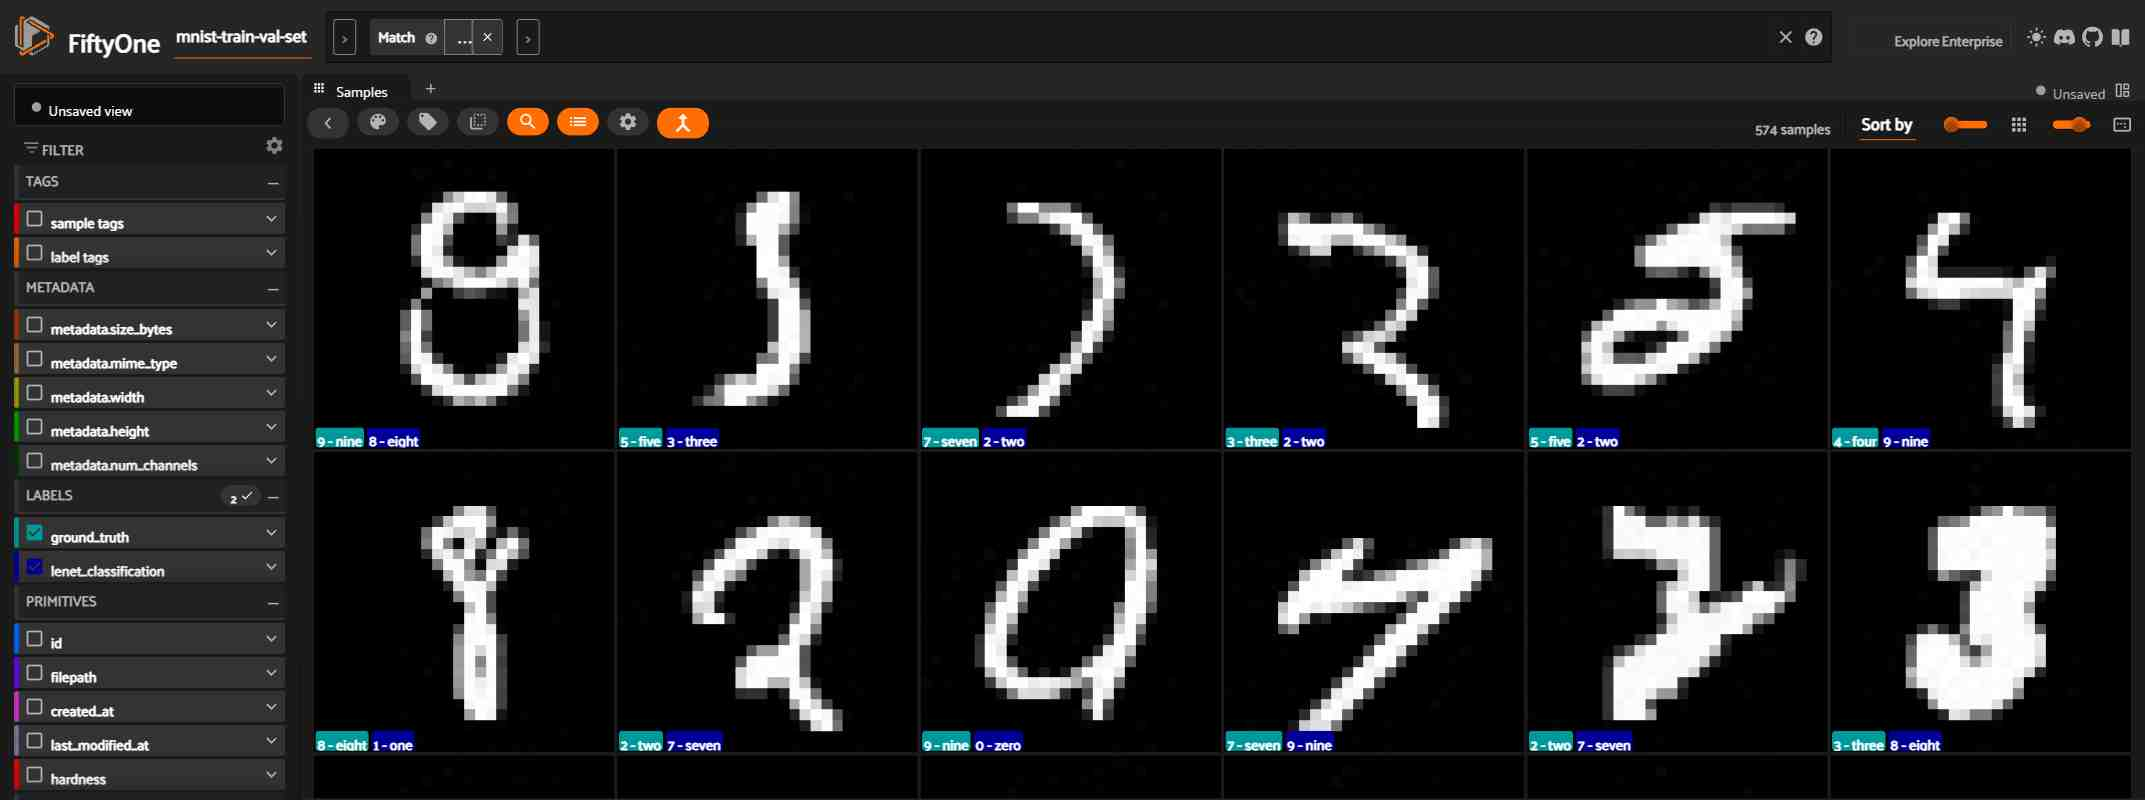

In [47]:
view(session, misclassified_view, train_val_dataset)

### Confidence

In [92]:
confidence_quantiles = train_val_dataset.quantiles("lenet_classification.confidence", [0.01, 0.05, 0.1, 0.25, 0.5] )
confidence_quantiles

[0.6648562550544739,
 0.9792491793632507,
 0.9978410005569458,
 0.9999545812606812,
 0.9999991655349731]

In [93]:
suspicious_confidence_train_val_view = train_val_dataset.match(
                             F("lenet_classification.confidence") < confidence_quantiles[0]
                             ).sort_by("lenet_classification.confidence", reverse=False)


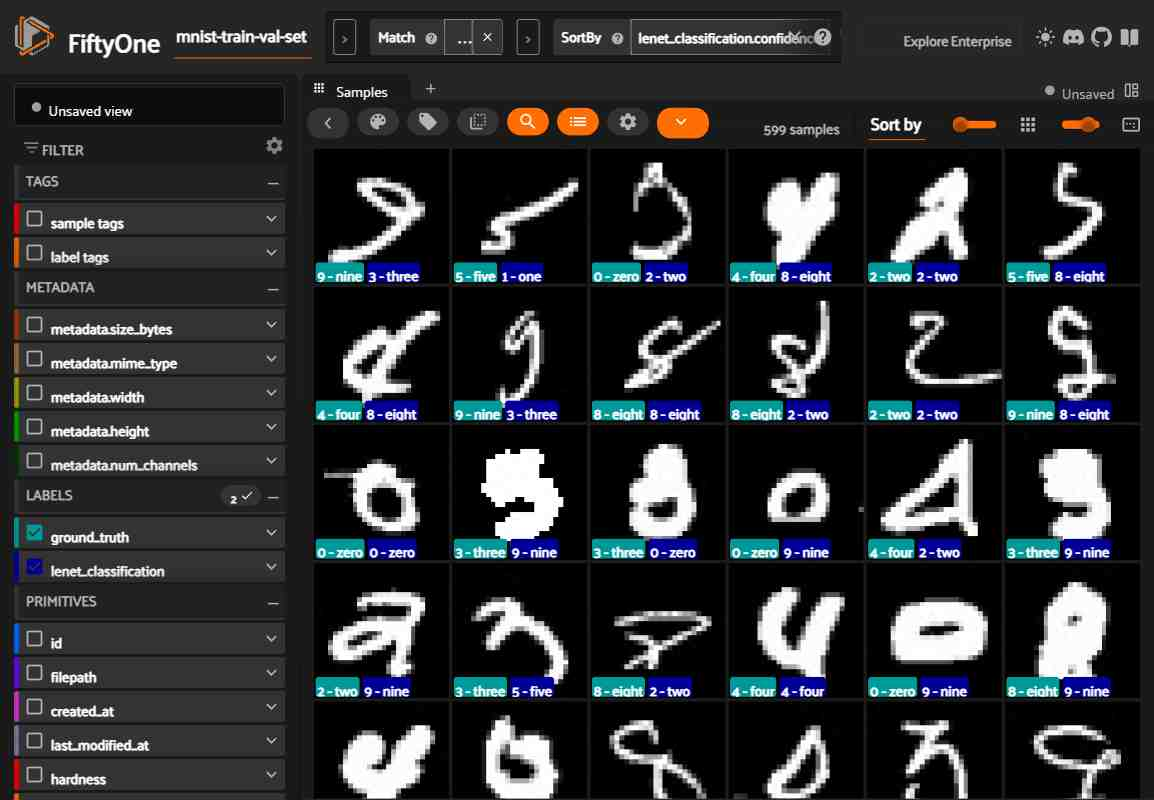

In [94]:
view(session, suspicious_confidence_train_val_view, train_val_dataset)

### Hardness

In [42]:
fob.compute_hardness(train_val_dataset,
                     label_field='lenet_classification',
                     )

Computing hardness...


 100% |█████████████| 60000/60000 [1.3m elapsed, 0s remaining, 802.3 samples/s]      
Hardness computation complete


In [96]:
# Compute quantiles of hardness
hardness_quantiles = train_val_dataset.quantiles("hardness", [0.5, 0.75, 0.95, 0.99, 0.999] )
hardness_quantiles

[1.3866502339659279e-05,
 0.000537466229402114,
 0.11681623246704548,
 0.8050221055441451,
 1.6303105875711106]

In [97]:
# Create a view showing only highly suspicious samples based on hardness
suspicious_hardness_train_val_view = train_val_dataset.match(
                             F("hardness") > hardness_quantiles[-1]
                             ).sort_by("hardness", reverse=True)


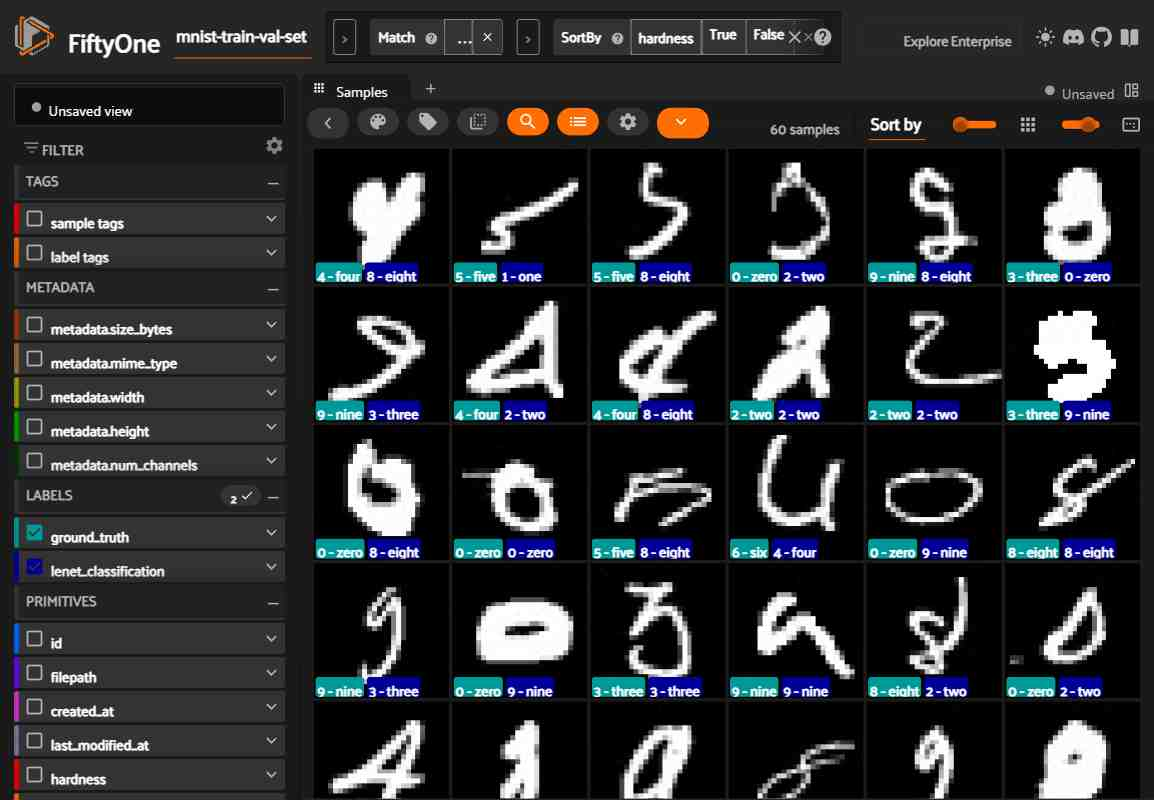

In [98]:
view(session, suspicious_hardness_train_val_view, train_val_dataset)

### Mistakeness

In [49]:
fob.compute_mistakenness(train_val_dataset,
                         pred_field="lenet_classification",
                         label_field="ground_truth")

Computing mistakenness...
 100% |█████████████| 60000/60000 [1.1m elapsed, 0s remaining, 918.6 samples/s]      
Mistakenness computation complete


In [99]:
# Compute quantiles of mistakeness
mistakenness_quantiles = train_val_dataset.quantiles("mistakenness", [0.5, 0.75, 0.95, 0.99, 0.999] )
mistakenness_quantiles

[4.172325134277344e-07,
 2.2709369659423828e-05,
 0.01099976897239685,
 0.29712042212486267,
 0.9874500632286072]

In [100]:
# Create a view showing only highly suspicious samples based on mistakenness
suspicious_mistakenness_train_val_view = train_val_dataset.match(
                             F("mistakenness") > mistakenness_quantiles[-1]
                             ).sort_by("mistakenness", reverse=True)


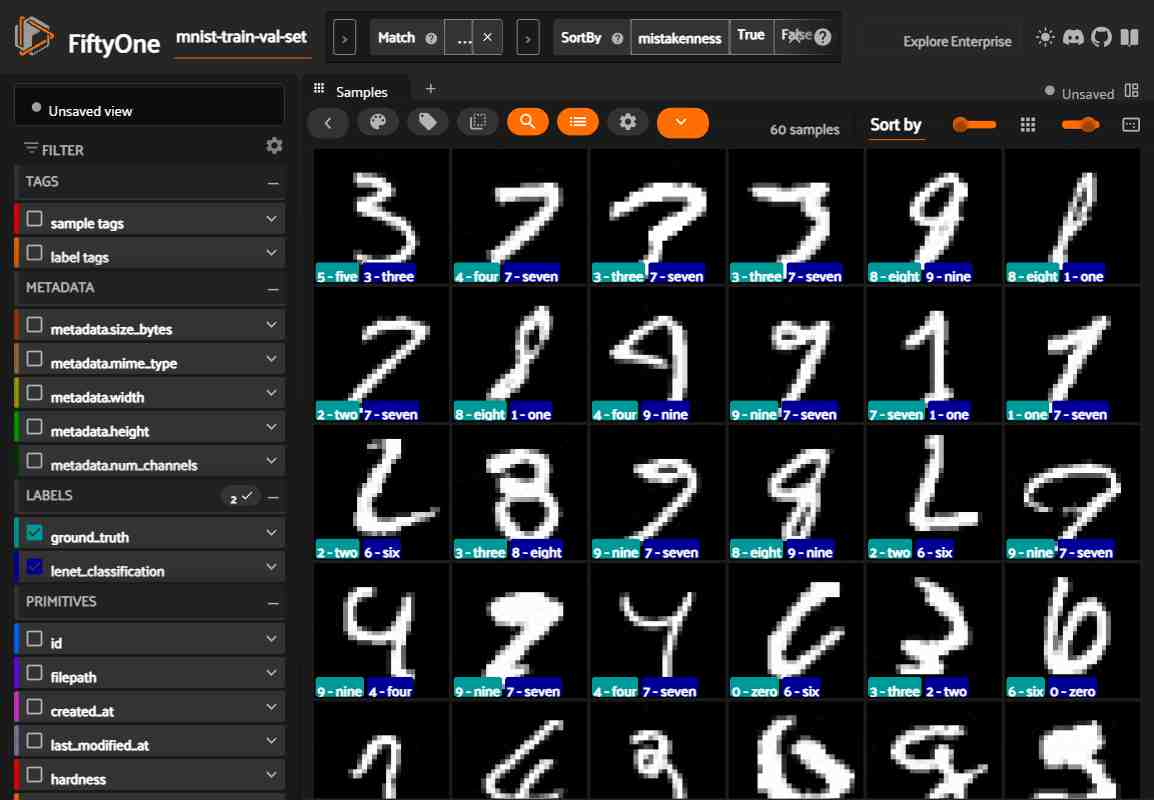

In [101]:
view(session, suspicious_mistakenness_train_val_view, train_val_dataset)

### Filter Samples for Data Curation

In [ ]:
# Identify samples which are likely annotation errors
mistakenness_99th_percentile = train_val_dataset.quantiles("mistakenness", [0.95])[0]
highly_mistaken_view = train_val_dataset.match(F("mistakenness") > mistakenness_99th_percentile)

# Identify samples which are likely genuinely hard samples
hardness_99th_percentile = train_val_dataset.quantiles("hardness", [0.95])[0]
highly_hard_view = train_val_dataset.match(F("hardness") > hardness_99th_percentile)

print(f"Number of highly mistaken samples (top 5%): {len(highly_mistaken_view)}")
print(f"Number of highly hard samples (top 5%): {len(highly_hard_view)}")

# Get the IDs of samples that are highly mistaken or highly hard
highly_mistaken_ids = set(highly_mistaken_view.values("id"))
highly_hard_ids = set(highly_hard_view.values("id"))

# Find the intersection of the annotation errors and genuinely hard samples
difficult_samples = highly_mistaken_ids.intersection(highly_hard_ids)

print(f"Total number of difficult samples (intersect of highly mistaken and highly hard): {len(difficult_samples)}")

Number of highly mistaken samples (top 5%): 3000
Number of highly hard samples (top 5%): 3000
Total number of difficult samples (intersect of highly mistaken and highly hard): 2925


In [ ]:
# A view of mislabeled images from the train_val set
mislabeled_train_images_view = train_val_dataset.match(
    (F("lenet_classification.label") != F("ground_truth.label"))
)
misclassified_sample_ids = set(mislabeled_train_images_view.values("id"))

print(f"Total number of misclassified samples in the train_val set: {len(misclassified_sample_ids)}")

# Find the intersection of difficult samples and misclassified samples
intersection_difficult_misclassified_ids = difficult_samples.intersection(misclassified_sample_ids)

print(f"Number of samples that are both difficult and misclassified: {len(intersection_difficult_misclassified_ids)}")

# Create a FiftyOne view containing only these intersection samples
intersection_difficult_misclassified_view = train_val_dataset.select(
    list(intersection_difficult_misclassified_ids)
    ).sort_by('hardness',
              reverse=True)

print(f"Created a FiftyOne view for the intersection samples with {len(intersection_difficult_misclassified_view)} samples.")

Total number of misclassified samples in the train_val set: 574
Number of samples that are both difficult and misclassified: 524
Created a FiftyOne view for the intersection samples with 524 samples.



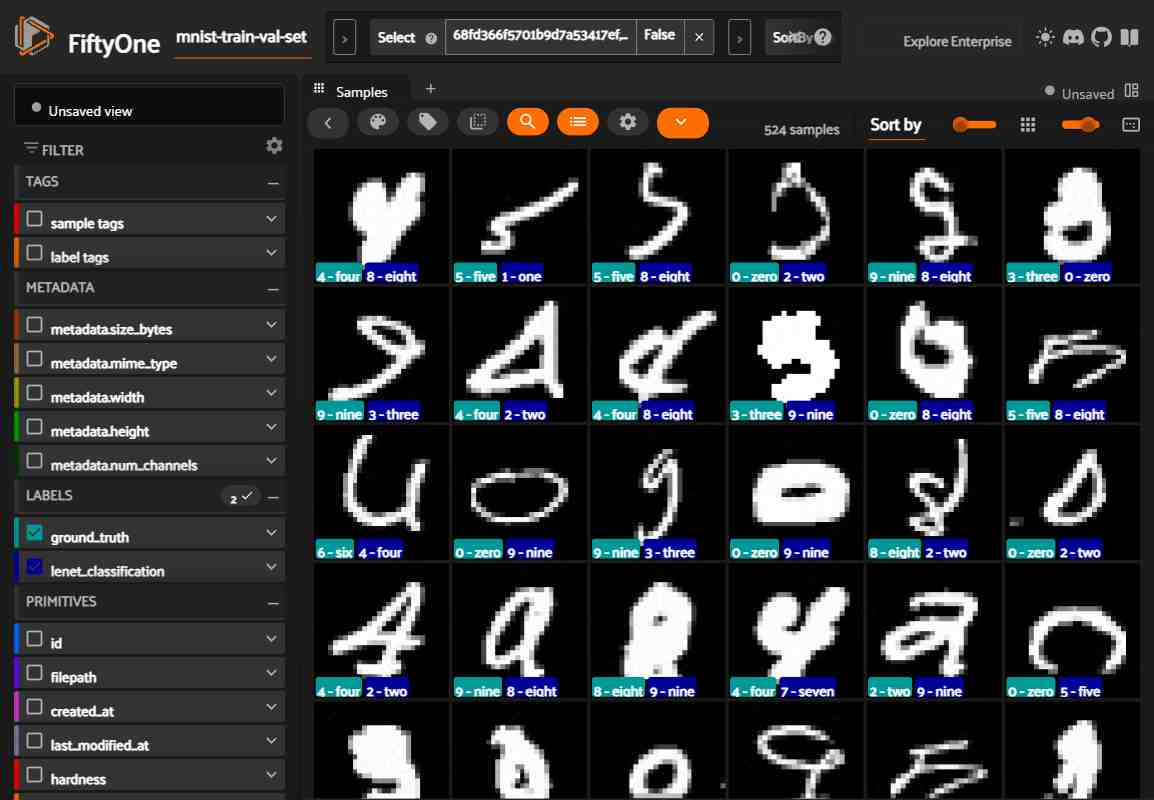

In [109]:
view(session, intersection_difficult_misclassified_view, train_val_dataset)

In [116]:
merged_dataset = fo.Dataset("curated-mnist")

# get the ids from samples_to_exclude_view
ids_of_samples_to_exclude = intersection_difficult_misclassified_view.values("id")

for sample in tqdm(train_val_dataset):
    sample.tags.append("exclude") if sample.id in ids_of_samples_to_exclude and "exclude" not in sample.tags else None
    if "lenet_classification" in sample:
        del sample["lenet_classification"]
    sample.save()
    merged_dataset.add_sample(sample)

for sample in tqdm(test_dataset):
    merged_dataset.add_sample(sample)

# Save the merged dataset
merged_dataset.persistent = True

print(f"Merged dataset created with {len(merged_dataset)} total samples")
print(f"Train/Val samples: {len(merged_dataset.match_tags('train/val'))}")
print(f"Test samples: {len(merged_dataset.match_tags('test'))}")

100%|██████████| 10000/10000 [00:19<00:00, 525.45it/s]


Merged dataset created with 70000 total samples
Train/Val samples: 0
Test samples: 10000


In [117]:
# Save merged_dataset to disk using FiftyOneDataset type
merged_dataset.export(
    export_dir=str(DATA_PATH / "curated_mnist_export"),
    dataset_type=fo.types.FiftyOneDataset,
    export_media=True
)

print(f"Merged dataset exported.")
print(f"Total samples exported: {len(merged_dataset)}")

Directory '/sc/home/josef.pribbernow/HPI-Applied-Hands-On-Computer-Vision-2025-Josef-Pribbernow/Assignment-01/data/curated_mnist_export' already exists; export will be merged with existing files
Exporting samples...
 100% |████████████████| 70000/70000 [8.3m elapsed, 0s remaining, 116.9 docs/s]      
Merged dataset exported.
Total samples exported: 70000


## Visualization of the Embedding Space

In [ ]:
## Extract Embeddings from LeNet Model Using PyTorch Hooks

def extract_lenet_embeddings(model, dataloader, device, layer_name='fc1'):
    """
    Extract embeddings from a specified layer of the LeNet model using PyTorch hooks.

    Args:
        model: Trained LeNet model
        dataloader: PyTorch DataLoader
        device: Device to run inference on
        layer_name: Name of the layer to extract embeddings from
                   Options: 'conv3', 'fc1', or 'fc2'

    Returns:
        numpy array of embeddings
    """

    embeddings_dict = {}

    def hook_fn(module, input, output):
        """Hook function to capture layer outputs"""

        if len(output.shape) > 2:
            embeddings_dict['embeddings'] = output.view(output.size(0), -1).cpu().detach()
        else:
            embeddings_dict['embeddings'] = output.cpu().detach()

    # Register the hook on the specified layer
    layer_map = {
        'conv3': model.conv3,  # Shape: (batch_size, 120, 1, 1)
        'fc1': model.fc1,     # Shape: (batch_size, 84)
        'fc2': model.fc2      # Shape: (batch_size, 10)
    }

    if layer_name not in layer_map:
        raise ValueError(f"Invalid layer_name. Choose from: {list(layer_map.keys())}")

    target_layer = layer_map[layer_name]
    hook_handle = target_layer.register_forward_hook(hook_fn)

    model.eval()
    all_embeddings = []

    print(f"Extracting embeddings from {layer_name} layer...")

    with torch.inference_mode():
        for images, _ in tqdm(dataloader, desc="Processing batches"):
            images = images.to(device)

            _ = model(images)

            batch_embeddings = embeddings_dict['embeddings'].numpy()
            all_embeddings.append(batch_embeddings)

    hook_handle.remove()
    final_embeddings = np.concatenate(all_embeddings, axis=0)

    print(f"Extracted embeddings shape: {final_embeddings.shape}")
    print(f"Embedding dimension: {final_embeddings.shape[1]}")

    return final_embeddings

In [ ]:
# Extract embeddings from the fc1 layer (84-dimensional representations)
print("Extracting LeNet embeddings with proper sample ordering...")

lenet_embeddings = extract_lenet_embeddings(
    model=loaded_model,
    dataloader=train_val_loader,
    device=device,
    layer_name='fc1'
)

embeddings_dict = {img_path: emb for img_path, emb in zip(torch_train_set.image_paths, lenet_embeddings)}

Extracting LeNet embeddings with proper sample ordering...
Extracting embeddings from fc1 layer...


Processing batches: 100%|██████████| 938/938 [00:44<00:00, 21.09it/s]

Extracted embeddings shape: (60000, 84)
Embedding dimension: 84


In [ ]:
print("Storing LeNet embeddings in FiftyOne dataset...")

for index, sample in enumerate(tqdm(train_val_dataset, desc="Storing embeddings")):
    sample["lenet_embeddings"] = lenet_embeddings[index]
    sample.save()

print("LeNet embeddings stored successfully in samples from train_val_dataset.")

sample = train_val_dataset.first()
print(f"Sample LeNet embedding shape: {sample.lenet_embeddings.shape}")
print(f"Embedding type: {type(sample.lenet_embeddings)}")
train_val_dataset.save()

Storing LeNet embeddings in FiftyOne dataset...


Storing embeddings: 100%|██████████| 60000/60000 [01:19<00:00, 754.92it/s]

LeNet embeddings stored successfully in samples from train_val_dataset.
Sample LeNet embedding shape: (84,)
Embedding type: <class 'numpy.ndarray'>


### PCA

In [133]:
# PCA visualization
pca_viz_lenet = fob.compute_visualization(
    train_val_dataset,
    method="pca",
    embeddings="lenet_embeddings",
    num_dims=2,
    brain_key="pca_lenet_embeddings",
    color_by="ground_truth.label"
)

Generating visualization...



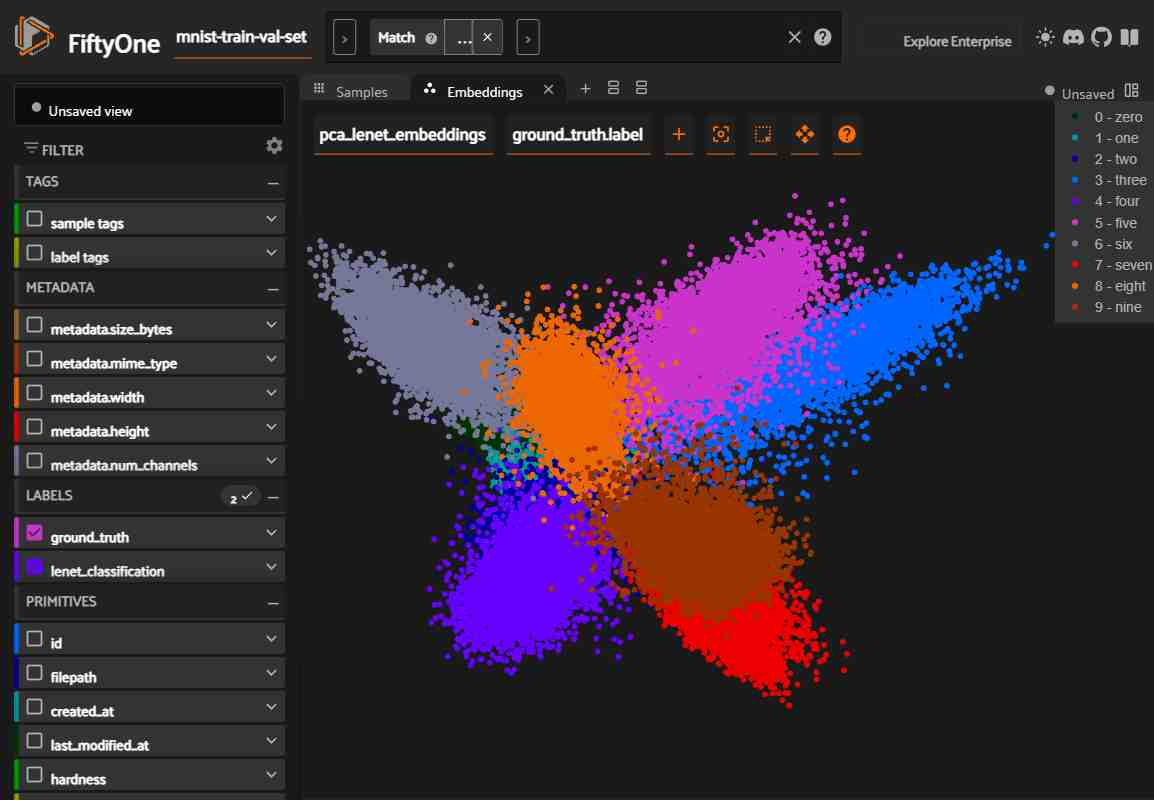

In [137]:
# Create a view, navigate to Embeddings tab in FiftyOne app to see PCA visualization
show_all = train_val_dataset.match(F("ground_truth.label"))
view(session, show_all, train_val_dataset)

### UMAP

In [135]:
# UMAP visualization
umap_viz_lenet = fob.compute_visualization(
    train_val_dataset,
    method="umap",
    embeddings="lenet_embeddings",
    num_dims=2,
    brain_key="umap_lenet_embeddings",
    color_by="ground_truth.label"
)

Generating visualization...
UMAP( verbose=True)
Sat Oct 25 20:12:09 2025 Construct fuzzy simplicial set
Sat Oct 25 20:12:09 2025 Finding Nearest Neighbors
Sat Oct 25 20:12:09 2025 Building RP forest with 17 trees
Sat Oct 25 20:12:10 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sat Oct 25 20:12:12 2025 Finished Nearest Neighbor Search
Sat Oct 25 20:12:13 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Oct 25 20:12:39 2025 Finished embedding



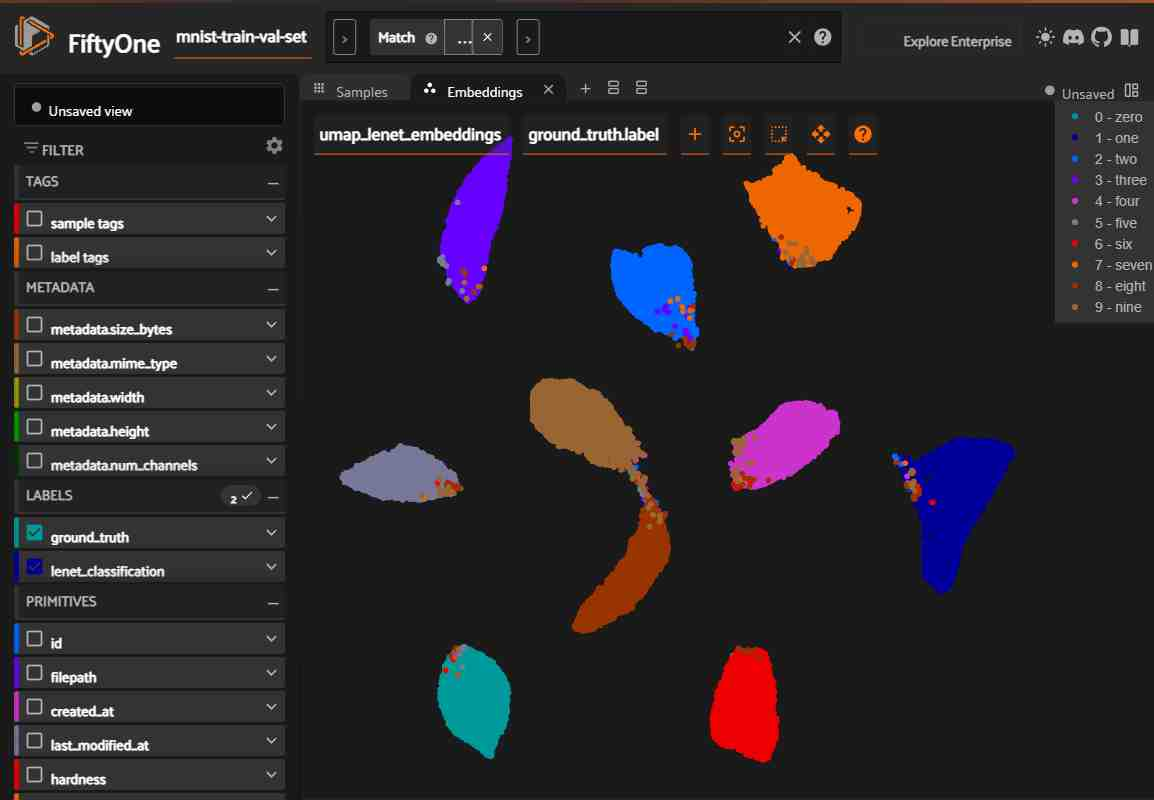

In [136]:
# Create a view, navigate to Embeddings tab in FiftyOne app to see UMAP visualization
show_all = train_val_dataset.match(F("ground_truth.label"))
view(session, show_all, train_val_dataset)

# Classifier with IDK

We will use a multi-label classification. Accordingly the classes will be 10 MNIST classes plus the IDK class.

### Data Preparation

In [ ]:
# Label all samples which difficult and misclassified with the IDK class
if dataset_names["train-val-IDK"] in fo.list_datasets():
    print(f"Dataset '{dataset_names['train-val-IDK']}' already exists. Loading it.")
    train_val_IDK_dataset = fo.load_dataset(dataset_names["train-val-IDK"])
else:
    print(f"Creating and preparing dataset '{dataset_names['train-val-IDK']}'...")
    train_val_IDK_dataset = train_val_dataset.clone()
    train_val_IDK_dataset.name = dataset_names["train-val-IDK"]
    train_val_IDK_dataset.persistent = True
    train_val_IDK_dataset.compute_metadata()
    train_val_IDK_dataset.untag_samples(["train", "validation"])
    for sample in tqdm(train_val_IDK_dataset, desc="Removing lenet_classification label"):
        if "lenet_classification" in sample:
            del sample["lenet_classification"]
        sample.save()

    for sample in tqdm(train_val_IDK_dataset, desc="Labeling IDK samples"):
        if sample.id in intersection_difficult_misclassified_ids:
            sample["ground_truth"].label = "10 - IDK"
            sample.save()

Dataset 'mnist-train-val-IDK-set' already exists. Loading it.


In [25]:
if not dataset_names["train-IDK"] in fo.list_datasets() or not dataset_names["val-IDK"] in fo.list_datasets():    
    # Create random 85%/15% split using tags
    four.random_split(train_val_IDK_dataset,
                    {"train": 0.85, "validation": 0.15},
                    # The seed makes the split reproducible
                    seed=SEED)

    # Verify the split by counting tags
    tag_counts = train_val_IDK_dataset.count_sample_tags()
    print("Tag counts after split:")
    print(tag_counts)

    # Separate validation and train FO datasets
    train_IDK_dataset = train_val_IDK_dataset.match_tags("train").clone()
    val_IDK_dataset = train_val_IDK_dataset.match_tags("validation").clone()

    # Set names for FO datasets using the 'name' property
    train_IDK_dataset.name = dataset_names["train-IDK"]
    val_IDK_dataset.name = dataset_names["val-IDK"]

    # Define persistency
    train_IDK_dataset.persistent = True
    val_IDK_dataset.persistent = True
else:
    print(f"Datasets '{dataset_names['train-IDK']}' and '{dataset_names['val-IDK']}' already exist. Loading them.")
    train_IDK_dataset = fo.load_dataset(dataset_names["train-IDK"])
    val_IDK_dataset = fo.load_dataset(dataset_names["val-IDK"])

Datasets 'mnist-train-IDK-set' and 'mnist-val-IDK-set' already exist. Loading them.


In [26]:
# Get Test Dataset
if dataset_names["test-IDK"] in fo.list_datasets():
    print(f"Dataset '{dataset_names['test-IDK']}' already exists. Loading it.")
    test_dataset_IDK = fo.load_dataset(dataset_names["test-IDK"])
else:
    print(f"Downloading and preparing dataset '{dataset_names['test-IDK']}'...")
    test_dataset_IDK = foz.load_zoo_dataset(
        "mnist",
        split="test",
        dataset_name=dataset_names["test-IDK"],
        persistent=True
    )
    test_dataset_IDK.compute_metadata()

    for sample in tqdm(test_dataset_IDK, desc="Removing lenet_classification label"):
        if "lenet_classification" in sample:
            del sample["lenet_classification"]
        sample.save()

Dataset 'mnist-test-IDK-set' already exists. Loading it.


In [27]:
# Get Label Map with IDK
dataset_classes = sorted(train_IDK_dataset.distinct("ground_truth.label"))
label_IDK_map = {
                '0 - zero': 0,
                '1 - one': 1,
                '2 - two': 2,
                '3 - three': 3,
                '4 - four': 4,
                '5 - five': 5,
                '6 - six': 6,
                '7 - seven': 7,
                '8 - eight': 8,
                '9 - nine': 9,
                '10 - IDK': 10
                }
label_IDK_map

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9,
 '10 - IDK': 10}

In [28]:
# Create a PyTorch Dataset for the train set
torch_train_IDK_set = CustomTorchImageDataset(train_IDK_dataset,
                                          label_map=label_IDK_map,
                                          image_transforms=IMAGE_TRANSFORMS)

# Create a PyTorch Dataset for the validation set
torch_val_IDK_set = CustomTorchImageDataset(val_IDK_dataset,
                                     label_map=label_IDK_map,
                                     image_transforms=IMAGE_TRANSFORMS)

# Create a PyTorch Dataset for the test set
torch_test_IDK_set = CustomTorchImageDataset(test_dataset_IDK,
                                      label_map=label_IDK_map,
                                      image_transforms=IMAGE_TRANSFORMS)

CustomTorchImageDataset initialized with 51000 samples.
CustomTorchImageDataset initialized with 9000 samples.
CustomTorchImageDataset initialized with 10000 samples.


In [ ]:
# Verify that the labels in torch_train_IDK_set include the IDK class
labelsss = []
for idx in range(len(torch_train_IDK_set)):
    _, label = torch_train_IDK_set[idx]
    labelsss.append(label.item())
labelsss = torch.tensor(labelsss)
print(labelsss.unique())

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])


In [ ]:
# Create a PyTorch DataLoader for the train set (shuffled for training)
train_IDK_train_loader = create_deterministic_training_dataloader(
    torch_train_IDK_set,
    batch_size=64,
    shuffle=True,  # keep shuffling during training
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
print("Train (training) DataLoader created successfully.")
print(f"Train (training) DataLoader has {len(train_IDK_train_loader)} batches.")

# Create a non-shuffled DataLoader for evaluation on the train set (preserves dataset order)
train_IDK_eval_loader = torch.utils.data.DataLoader(
    torch_train_IDK_set,
    batch_size=64,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
print("Train (evaluation) DataLoader created successfully.")
print(f"Train (evaluation) DataLoader has {len(train_IDK_eval_loader)} batches.")

# Create a PyTorch DataLoader for the validation set
val_IDK_loader = torch.utils.data.DataLoader(
    torch_val_IDK_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
print("Validation DataLoader created successfully.")
print(f"Validation DataLoader has {len(val_IDK_loader)} batches.")

# Create a PyTorch DataLoader for the test set
test_IDK_loader = torch.utils.data.DataLoader(
    torch_test_IDK_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

print("Test DataLoader created successfully.")
print(f"Test DataLoader has {len(test_IDK_loader)} batches.")

Train (training) DataLoader created successfully.
Train (training) DataLoader has 797 batches.
Train (evaluation) DataLoader created successfully.
Train (evaluation) DataLoader has 797 batches.
Validation DataLoader created successfully.
Validation DataLoader has 282 batches.
Test DataLoader created successfully.
Test DataLoader has 313 batches.


In [ ]:
# Verify that the DataLoader for train_IDK_dataset includes the IDK class
labelsss = []
for images, labels in train_IDK_train_loader:
    labelsss.extend(labels.tolist())
labelsss = torch.tensor(labelsss)
print(labelsss.unique())

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])


### Model Definition & Training

In [33]:
model = ModernLeNet5(num_classes=11).to(device)

ce_loss = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),
                 lr=0.003, betas=(0.9, 0.999),
                 eps=1e-08, weight_decay=0)

In [ ]:
num_epochs = 1
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_model = None

model_save_path = MODEL_PATH / 'best_lenet_IDK.pth'

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_IDK_train_loader)
    val_loss, val_acc = val_epoch(model, val_IDK_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

        torch.save(best_model.state_dict(), model_save_path)
        print('Found and saved better weights for the model')

Validation: 100%|██████████| 282/282 [00:06<00:00, 43.95it/s]


Epoch 1/10 - Train Loss: 0.0326 - Train Acc: 0.9907 - Val Loss: 0.0742 - Val Acc: 0.9856
Found and saved better weights for the model


Validation: 100%|██████████| 282/282 [00:06<00:00, 45.66it/s]


Epoch 2/10 - Train Loss: 0.0285 - Train Acc: 0.9921 - Val Loss: 0.0540 - Val Acc: 0.9893
Found and saved better weights for the model


Validation: 100%|██████████| 282/282 [00:06<00:00, 41.43it/s]


Epoch 3/10 - Train Loss: 0.0255 - Train Acc: 0.9933 - Val Loss: 0.0608 - Val Acc: 0.9872


Validation: 100%|██████████| 282/282 [00:09<00:00, 30.75it/s]


Epoch 4/10 - Train Loss: 0.0284 - Train Acc: 0.9921 - Val Loss: 0.0617 - Val Acc: 0.9872


Validation: 100%|██████████| 282/282 [00:06<00:00, 43.73it/s]


Epoch 5/10 - Train Loss: 0.0228 - Train Acc: 0.9936 - Val Loss: 0.0702 - Val Acc: 0.9867


Validation: 100%|██████████| 282/282 [00:06<00:00, 43.66it/s]


Epoch 6/10 - Train Loss: 0.0260 - Train Acc: 0.9929 - Val Loss: 0.0529 - Val Acc: 0.9889
Found and saved better weights for the model


Validation: 100%|██████████| 282/282 [00:06<00:00, 43.76it/s]


Epoch 7/10 - Train Loss: 0.0255 - Train Acc: 0.9935 - Val Loss: 0.0646 - Val Acc: 0.9866


Validation: 100%|██████████| 282/282 [00:06<00:00, 44.20it/s]


Epoch 8/10 - Train Loss: 0.0257 - Train Acc: 0.9935 - Val Loss: 0.0692 - Val Acc: 0.9870


Validation: 100%|██████████| 282/282 [00:05<00:00, 47.60it/s]


Epoch 9/10 - Train Loss: 0.0239 - Train Acc: 0.9937 - Val Loss: 0.0680 - Val Acc: 0.9882


Validation: 100%|██████████| 282/282 [00:06<00:00, 45.18it/s]

Epoch 10/10 - Train Loss: 0.0223 - Train Acc: 0.9945 - Val Loss: 0.0662 - Val Acc: 0.9866


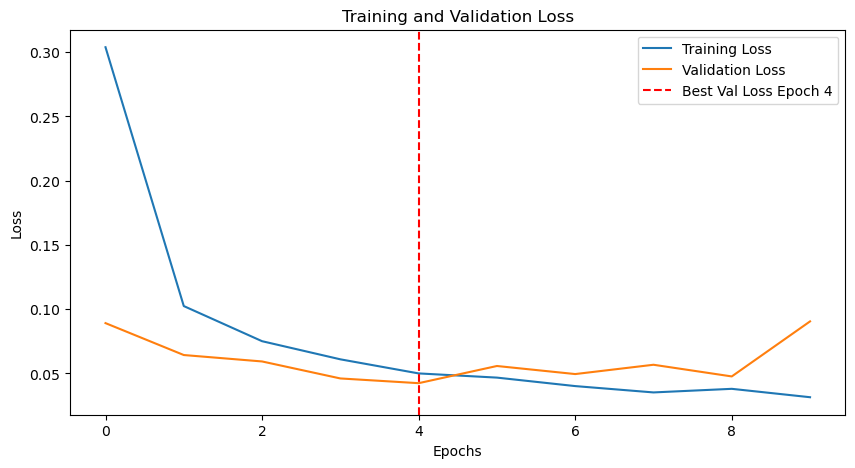

In [ ]:
plt.figure(figsize=(num_epochs, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

best_epoch = np.argmin(val_losses)
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Val Loss Epoch {best_epoch}')
plt.legend()

plt.savefig(EXAMPLES_PATH / "training_validation_loss_IDK.png")
plt.show()

### Model Evaluation

In [112]:
model_save_path = MODEL_PATH / 'best_lenet_IDK.pth'
device = "cuda" if torch.cuda.is_available() else "cpu"

loaded_model_IDK = ModernLeNet5(num_classes=11)
loaded_model_IDK.load_state_dict(torch.load(model_save_path, map_location=device))
loaded_model_IDK = loaded_model_IDK.to(device)

print(f"Model loaded.")
print(f"Model is on device: {next(loaded_model_IDK.parameters()).device}")
loaded_model_IDK.eval()

Model loaded.
Model is on device: cuda:0


ModernLeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=11, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

### On Test Set

The Test Set doesn't have any IDK Labels as ground truths. That is why we will compare the original model with this one in terms of how many of the previously misclassified samples are now classified as IDK.

In [ ]:
## Apply best_model to the test set
apply_model_to_evaluate(
    model=loaded_model_IDK,
    loader=test_IDK_loader,
    dataset=test_dataset_IDK,
    set_name="test-IDK",
    label_map=label_IDK_map
)

Applying best LeNet model to the test-IDK set...


100%|██████████| 313/313 [00:07<00:00, 39.91it/s]


Inference on test-IDK set complete.
Shape of collected logits: (10000, 11)
Number of collected predictions: 10000
Storing predictions and logits as FiftyOne Classifications for the test-IDK set...


In [75]:
lenet_evaluation_results = test_dataset_IDK.evaluate_classifications(
    "lenet_classification",
    gt_field="ground_truth",
    eval_key="lenet_eval")

lenet_evaluation_results.print_report(digits=3)

              precision    recall  f1-score   support

    0 - zero      0.993     0.993     0.993       980
     1 - one      0.993     0.991     0.992      1135
    10 - IDK      0.000     0.000     0.000         0
     2 - two      0.990     0.987     0.989      1032
   3 - three      0.990     0.987     0.989      1010
    4 - four      0.991     0.988     0.989       982
    5 - five      0.988     0.982     0.985       892
     6 - six      0.993     0.982     0.987       958
   7 - seven      0.989     0.985     0.987      1028
   8 - eight      0.988     0.988     0.988       974
    9 - nine      0.992     0.971     0.981      1009

    accuracy                          0.986     10000
   macro avg      0.901     0.896     0.898     10000
weighted avg      0.991     0.986     0.988     10000



In [77]:
idk_test_set_view = test_dataset_IDK.match(
    F("lenet_classification.label") == "10 - IDK"
)

print(f"Number of samples classified as IDK in test-IDK set: {len(idk_test_set_view)}")

Number of samples classified as IDK in test-IDK set: 51


### On Train Set

In [78]:
## Apply best_model to the train set, store logits and confidence
apply_model_to_evaluate(
    model=loaded_model_IDK,
    loader=train_IDK_eval_loader,
    dataset=train_IDK_dataset,
    set_name="train-IDK",
    label_map=label_IDK_map,
)

Applying best LeNet model to the train-IDK set...


100%|██████████| 797/797 [00:38<00:00, 20.57it/s]


Inference on train-IDK set complete.
Shape of collected logits: (51000, 11)
Number of collected predictions: 51000
Storing predictions and logits as FiftyOne Classifications for the train-IDK set...


In [79]:
lenet_evaluation_results = train_IDK_dataset.evaluate_classifications(
    "lenet_classification",
    gt_field="ground_truth",
    eval_key="lenet_eval")

lenet_evaluation_results.print_report(digits=3)

              precision    recall  f1-score   support

    0 - zero      0.994     1.000     0.997      5001
     1 - one      0.997     0.998     0.998      5688
    10 - IDK      0.594     0.234     0.336       431
     2 - two      0.994     0.997     0.996      5025
   3 - three      0.993     0.996     0.995      5208
    4 - four      0.986     0.999     0.993      4915
    5 - five      0.991     0.999     0.995      4562
     6 - six      0.996     0.997     0.997      4970
   7 - seven      0.996     0.997     0.996      5310
   8 - eight      0.989     0.997     0.993      4889
    9 - nine      0.984     0.991     0.988      5001

    accuracy                          0.991     51000
   macro avg      0.956     0.928     0.935     51000
weighted avg      0.989     0.991     0.989     51000



In [80]:
idk_train_set_view = train_IDK_dataset.match(
    F("lenet_classification.label") == "10 - IDK"
)

print(f"Number of samples classified as IDK in train-IDK set: {len(idk_train_set_view)}")

Number of samples classified as IDK in train-IDK set: 170


### On Validation Set

In [81]:
## Apply best_model to the val set, store logits and confidence
apply_model_to_evaluate(
    model=loaded_model_IDK,
    loader=val_IDK_loader,
    dataset=val_IDK_dataset,
    set_name="val-IDK",
    label_map=label_IDK_map
)

Applying best LeNet model to the val-IDK set...


100%|██████████| 282/282 [00:06<00:00, 44.36it/s]


Inference on val-IDK set complete.
Shape of collected logits: (9000, 11)
Number of collected predictions: 9000
Storing predictions and logits as FiftyOne Classifications for the val-IDK set...


In [82]:
lenet_evaluation_results = val_IDK_dataset.evaluate_classifications(
    "lenet_classification",
    gt_field="ground_truth",
    eval_key="lenet_eval")

lenet_evaluation_results.print_report(digits=3)

              precision    recall  f1-score   support

    0 - zero      0.993     0.998     0.995       868
     1 - one      0.995     0.994     0.995      1040
    10 - IDK      0.361     0.140     0.202        93
     2 - two      0.990     0.991     0.990       888
   3 - three      0.986     0.990     0.988       858
    4 - four      0.978     0.992     0.985       858
    5 - five      0.973     0.991     0.982       787
     6 - six      0.985     0.988     0.986       917
   7 - seven      0.988     0.994     0.991       927
   8 - eight      0.976     0.989     0.982       891
    9 - nine      0.978     0.982     0.980       873

    accuracy                          0.982      9000
   macro avg      0.928     0.913     0.916      9000
weighted avg      0.978     0.982     0.980      9000



In [83]:
idk_val_set_view = val_IDK_dataset.match(
    F("lenet_classification.label") == "10 - IDK"
)

print(f"Number of samples classified as IDK in val-IDK set: {len(idk_val_set_view)}")

Number of samples classified as IDK in val-IDK set: 36


### On the Train/Validation Set

In [84]:
# Create a PyTorch Dataset for the train_val set
torch_train_val_IDK_set = CustomTorchImageDataset(train_val_IDK_dataset,
                                               label_map=label_IDK_map,
                                               image_transforms=IMAGE_TRANSFORMS)

# Create a PyTorch DataLoader for the train_val set
train_val_IDK_loader = create_deterministic_training_dataloader(
    torch_train_val_IDK_set,
    batch_size=64,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
print("Train DataLoader created successfully.")
print(f"Train DataLoader has {len(train_val_IDK_loader)} batches.")

CustomTorchImageDataset initialized with 60000 samples.
Train DataLoader created successfully.
Train DataLoader has 938 batches.


In [85]:
## Apply best_model to the train_validation set, store logits and confidence
apply_model_to_evaluate(
    model=loaded_model_IDK,
    loader=train_val_IDK_loader,
    dataset=train_val_IDK_dataset,
    set_name="train_val_IDK",
    label_map=label_IDK_map
)

Applying best LeNet model to the train_val_IDK set...


100%|██████████| 938/938 [00:45<00:00, 20.70it/s]


Inference on train_val_IDK set complete.
Shape of collected logits: (60000, 11)
Number of collected predictions: 60000
Storing predictions and logits as FiftyOne Classifications for the train_val_IDK set...


In [86]:
lenet_evaluation_results = train_val_IDK_dataset.evaluate_classifications(
    "lenet_classification",
    gt_field="ground_truth",
    eval_key="lenet_eval")

lenet_evaluation_results.print_report(digits=3)

              precision    recall  f1-score   support

    0 - zero      0.994     0.999     0.997      5869
     1 - one      0.997     0.998     0.997      6728
    10 - IDK      0.553     0.218     0.312       524
     2 - two      0.993     0.996     0.995      5913
   3 - three      0.992     0.995     0.994      6066
    4 - four      0.985     0.998     0.991      5773
    5 - five      0.988     0.998     0.993      5349
     6 - six      0.994     0.996     0.995      5887
   7 - seven      0.995     0.996     0.996      6237
   8 - eight      0.987     0.996     0.992      5780
    9 - nine      0.983     0.990     0.986      5874

    accuracy                          0.990     60000
   macro avg      0.951     0.926     0.932     60000
weighted avg      0.987     0.990     0.988     60000



In [87]:
idk_train_val_set_view = train_val_IDK_dataset.match(
    F("lenet_classification.label") == "10 - IDK"
)

print(f"Number of samples classified as IDK in train_val-IDK set: {len(idk_train_val_set_view)}")

Number of samples classified as IDK in train_val-IDK set: 206


Number of misclassified samples in original train_val set: 574
Number of samples classified as IDK in train_val-IDK set: 206
Number of previously misclassified samples now classified as IDK: 119
Fraction: 0.207


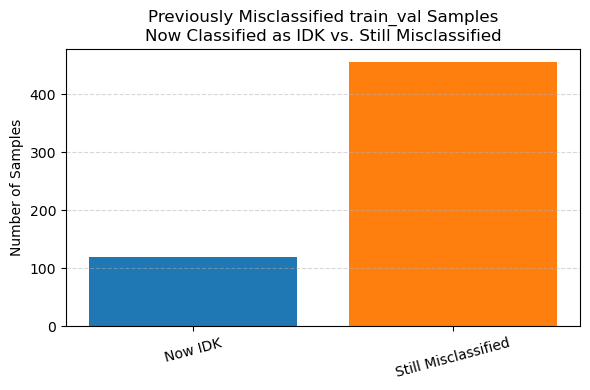

In [90]:
# Get IDs of misclassified samples in the original train_val set
misclassified_train_val_view = train_val_dataset.match(
    F("lenet_classification.label") != F("ground_truth.label") 
)
misclassified_train_val_ids = set(misclassified_train_val_view.values("id"))

print(f"Number of misclassified samples in original train_val set: {len(misclassified_train_val_ids)}")

idk_train_val_set_view = train_val_IDK_dataset.match(
    F("lenet_classification.label") == "10 - IDK"
)

print(f"Number of samples classified as IDK in train_val-IDK set: {len(idk_train_val_set_view)}")

# We use the intersection of misclassified_train_val_ids and idk_train_val_set_view ids
idk_train_val_ids = set(idk_train_val_set_view.values("id"))
misclassified_now_IDK = misclassified_train_val_ids.intersection(idk_train_val_ids)

print(f"Number of previously misclassified samples now classified as IDK: {len(misclassified_now_IDK)}")
print(f"Fraction: {len(misclassified_now_IDK) / len(misclassified_train_val_ids):.3f}")

# Calculate numbers
num_total = len(misclassified_train_val_ids)
num_idk = len(misclassified_now_IDK)
num_other = num_total - num_idk

# Bar plot
plt.figure(figsize=(6, 4))
plt.bar(['Now IDK', 'Still Misclassified'], [num_idk, num_other], color=['tab:blue', 'tab:orange'])
plt.ylabel('Number of Samples')
plt.title('Previously Misclassified train_val Samples\nNow Classified as IDK vs. Still Misclassified')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()